# Lab 3 — clustering

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pickle

%matplotlib inline
plt.style.use("ggplot")

## 3.11 Clustering tags

In [2]:
from sklearn.cluster import KMeans

First we reload the data from our file (Stored in part 1)

In [3]:
#We have a dict from tag name to 5-dim position
with open("nameToNewSpace.pickle", "rb") as f:
    tagsToCoord = pickle.load(f, encoding="utf-8")

FileNotFoundError: [Errno 2] No such file or directory: 'nameToNewSpace.pickle'

Now we create two lists from the dict, to preserve the order between the keys (named tags, containing the name of the tags) and the values (named coords, containing the 5 values of the 5 dimensions). We also do the KMeans algorithm with different number of clusters (here from 2 to 5). labels_ _is the attribute returning the list which gives the number of the cluster for each point

In [61]:
tags = list()
coords = list()
for k in tagsToCoord :
    tags.append(k)
    coords.append(tagsToCoord[k])

#coords = list(tagsToCoord.values())
kmeans2 = KMeans(n_clusters = 2).fit(coords)
kmeans3 = KMeans(n_clusters = 3).fit(coords)
kmeans4 = KMeans(n_clusters = 4).fit(coords)
kmeans5 = KMeans(n_clusters = 5).fit(coords)
set(kmeans2.labels_) # values are 0 and 1

In [6]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

We implement the visualisation of the clusters :
- source is the input, we give the coordinates of the 2 dimensions we want to represent, the name of the point (here it is the name of the tag) and the color which corresponds to the number of the cluster
- we activate the tool to display the tag when we place the mouse over a point
- we create the plot

In [70]:
# Categorial colors
from bokeh.palettes import Dark2_8

source = ColumnDataSource(
    data={
        "x": [x[0] for x in coords], #Need to check different pairs of coordinates(between the 5)
        "y": [x[1] for x in coords], 
        "name": [x for x in tags],
        "color": [Dark2_8[x] for x in kmeans3.labels_]
    })

hover = HoverTool(
    tooltips=[
        ("Tag", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=360, tools=tools, title="Mouse over the dots")
p.circle("x", "y", source=source, size=20, color="color", alpha=0.5)
show(p, notebook_handle=True)

We can see that the data cluster well with 3 clusters on the dimensions of the highest eigen vectors (the first and second coordinates in the 5 dimension array)

## Clustering Movies

Overview of the content of the movies.txt file :

In [7]:
!hdfs dfs -cat /ix/ml-20m/movies.txt | tail -n 2

{"genres": ["(no genres listed)"], "movieId": 131260, "title": "Rentun Ruusu (2001)"}
{"genres": ["Adventure", "Fantasy", "Horror"], "movieId": 131262, "title": "Innocence (2014)"}


In [8]:
from operator import itemgetter

We create a dict with the data from the file to match a movieId (an integer) with its set of genres associated (a set of strings)

In [9]:
data = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
movieIdToGenre = dict(data.map(itemgetter("movieId", "genres")).collect())

Exemple of use of our dict :

In [10]:
movieIdToGenre[131262]

['Adventure', 'Fantasy', 'Horror']

In [11]:
import random

We implement the Jaccard distance function to evaluate the non-Euclidean distance between sets, it will be use to compute the "distance" between sets of genres

In [12]:
def JaccardDist(A,B):
    #We treat the special case of both null sets to avoid any division by 0
    if len(A) == 0 and len(B) == 0:
        return 1
    else:
        return 1- len(A.intersection(B))/len(A.union(B))

Exemple of use :

In [13]:
JaccardDist(set({1,3,5,6}), set({1,6}))

0.5

In [122]:
#This function uses a distance function, an array and an instance (set of genres in our case)
#Return : Array of the distance between every point of input array and instance
#with respect to the given distance function
def distOnArray(dist, tab, x):
    res = np.zeros(len(tab))
    for y in range(len(tab)):
        res[y] = dist(tab[y], x)
    return res

#This function uses a distance function, an instance (set of genres in our case) and a list of instances
#Return : the sum of the distances between every element of the list with the instance
#with respect to the given distance function
def sumOnC(dist, x, C):
    sum = 0
    for y in C:
        sum += dist(x,y)
    return sum

#This function uses a distance function and a list of instances (set of genres in our case)
#Return : the instance in the list that minimizes the sum of distances on all instances of
#the list. 
def bs(dist, C):
    x_res = set([])
    sum_x = 100000
    for x in C:
        curr_sum = sumOnC(dist, x, C)
        if(curr_sum < sum_x):
            sum_x = curr_sum
            x_res = x
    return x_res

#We create outside of the kMediods function the data structure to receive the 2 clusters
#in order to reuse them to plot the frequencies
#This data structure is an array of 2 lists of sets of genres
#Explanation : as we do an argmin action, we need to access the lists by an index, which
#gives us the array. Then we don't know in advance how many items will be in each cluster,
#which implies the use of lists, in order to add dynamically items. Finally the items are
#the set of genres associated with a movie.
"""C = [None]*2
liste0 = []
liste1 = []
C[0] = liste0
C[1] = liste1

def kMedioids(X, dist, k):
    m = random.sample(X, k) #m is an array of k sets of genres which reprensents the "centers"
    index = -1;
    m_prev = np.array([set([]), set([])]) #previous result of the "centers" to check convergence
    while(dist(m[0], m_prev[0]) > 0.0000001 and dist(m[1], m_prev[1]) > 0.0000001):
        m_prev = m.copy()
        for j in range(k):
            C[j] = []
        for x in X:
            #Find the index of cluster where x belongs for every element
            index = np.argmin(distOnArray(dist, m, x))
            #Append x to the correct cluster
            C[index].append(x);
        for j in range(k):
            #Once redistributed all the items, we recompute the best "center" for each cluster
            m[j] = bs(dist, C[j])
    #We return the final "centers" of each cluster as an array of items
    return m"""
            

In [ ]:
def checkConvergence(m, m_prev, k, threshold):
    res = True
    for i in range(k):
        res = res and dist(m[i], m_prev[i]) > threshold
    return res

In [ ]:
def kMedioids(X, dist, k):
    C = [None]*k
    for i in range(k):
        listei = []
        C[i] = listei
    m = random.sample(X, k) #m is an array of k sets of genres which reprensents the "centers"
    index = -1;
    m_prev = np.array([set([]), set([])]) #previous result of the "centers" to check convergence
    while(checkConvergence(m, m_prev, k, 0.0000001)):
        m_prev = m.copy()
        for j in range(k):
            C[j] = []
        for x in X:
            #Find the index of cluster where x belongs for every element
            index = np.argmin(distOnArray(dist, m, x))
            #Append x to the correct cluster
            C[index].append(x);
        for j in range(k):
            #Once redistributed all the items, we recompute the best "center" for each cluster
            m[j] = bs(dist, C[j])
    #We return the final "centers" of each cluster as an array of items
    return (C, m)

In the most rated file we only have access to movieId and title of the movie

In [15]:
with open("most-rated.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
len(movies)

1000

So we create a list of the sets of genres associated to each movieId in most-rated.pickle thanks to our previous dictionary

In [19]:
ratedMovies = list()
for (id, name) in movies:
    ratedMovies.append(set(movieIdToGenre[id])) 

In [20]:
len(ratedMovies)

1000

We run the kMedioids and print the centers of the 2 clusters

In [123]:
C, representatives = kMedioids(ratedMovies, JaccardDist, 2) 
representatives

[{'Drama', 'Crime'}, {'Drama', 'Children', 'Fantasy'}]


[{'Comedy', 'Drama'},
 {'Action', 'Adventure', 'Children', 'Comedy', 'Fantasy', 'Sci-Fi'}]

We create a function that given a cluster (as a list of sets) will return the list of keys and the list of associated frequencies

In [152]:
def clusterToGenreFreq(C):
    #Create a dict which will receive the genre as key and count the number of appearences in C
    genreToFreq = {}
    nbGenres = 0
    for x in C:
        for g in x:
            try:
                #Add 1 to value if key already exist
                genreToFreq[g] += 1
            except KeyError:
                #If key doesn't exist, create and initialize value at 1
                genreToFreq[g] = 1
            nbGenres +=1
    values = [] #Create list to store values in same order as traversing keys
    keys = [] #also needed to preserve order
    for key in clusterOneFreq.keys():
        keys.append(key)
        #When adding the value divide by the total number of genres in C to get percentages
        values.append(clusterOneFreq[key]/nbGenres)
    return (keys, values)

In [153]:
keysOne, valuesOne = clusterToGenreFreq(C[0])
keysTwo, valuesTwo = clusterToGenreFreq(C[1])

We display the frequencies as a bar chart, with as x-axis values the name of the tag and y-axis values the frequencie. We do this for both clusters

In [ ]:
def showBarChart(keys, values):
    ind = np.arange(len(keys))
    plt.bar(ind, values)
    plt.xticks(ind, keys,rotation = 90)
    plt.yticks(np.arange(0, 1, 0.1))
    plt.show()

In [ ]:
showBarChart(keysOne, valuesOne)
showBarChart(keysTwo, valuesTwo)

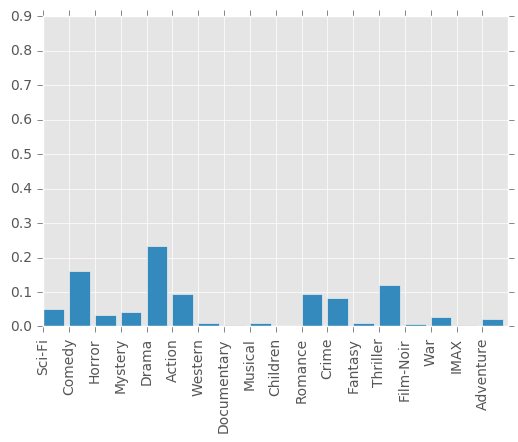

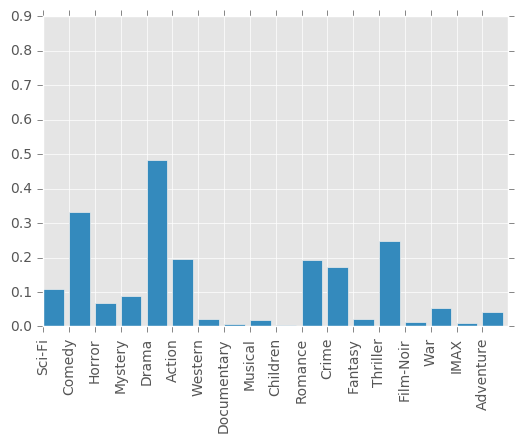

In [159]:
"""indOne = np.arange(len(keysOne))
plt.bar(indOne, valuesOne)
plt.xticks(indOne, keysOne,rotation = 90)
plt.yticks(np.arange(0, 1, 0.1))
plt.show()

indTwo = np.arange(len(keysTwo))
plt.bar(indTwo, valuesTwo)
plt.xticks(indTwo, keysTwo, rotation = 90)
plt.yticks(np.arange(0, 1, 0.1))
plt.show()"""